In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch

In [3]:
import datasets, models, interpretation, utils

# Load model, dataset and brain area masks

In [4]:
net = models.ClassificationModel3D()
net.load_state_dict(torch.load('output/models/softmax-output_state-dict.pt'))

C:\Users\abc\AppData\Local\Temp\ipykernel_16892\3196439524.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('output/models/softmax-output_s

<All keys matched successfully>

In [5]:
if torch.cuda.is_available():
    net.cuda()
    cuda_device = torch.cuda.current_device()
    print('Moved network to GPU')
else:
    cuda_device = -1
    print('GPU not available')

GPU not available


In [6]:
# Important: Set model to eval before using any interpretation methods
net.eval();

In [7]:
# Load the data table with all 3 Tesla MRI scans from ADNI.
# df = datasets.load_data_table_15T()
table_train = r'C:\AD_detection_v2\ADNI1_Screening_1.5T_8_25_2024_Train.csv'
image_dir= r'D:\ADNI data'
table_test = r'C:\AD_detection_v2\ADNI1_Screening_1.5T_8_25_2024_Test.csv'

df_train = datasets.load_data_table(table_train,image_dir)
df_test = datasets.load_data_table(table_test,image_dir)

Loading dataframe for C:\AD_detection_v2\ADNI1_Screening_1.5T_8_25_2024_Train.csv
Found 224 images in table
Filtered out 0 of 224 images because of failed preprocessing
Filtered out 0 of 224 images because of missing files
Final dataframe contains 224 images from 224 patients

Loading dataframe for C:\AD_detection_v2\ADNI1_Screening_1.5T_8_25_2024_Test.csv
Found 103 images in table
Filtered out 0 of 103 images because of failed preprocessing
Filtered out 0 of 103 images because of missing files
Final dataframe contains 103 images from 103 patients



In [8]:
df_test.head()

Image Data ID     Subject Group Sex  Age Visit Modality  \
0       I102040  099_S_1144    AD   M   78    sc      MRI   
1       I112292  141_S_0853    AD   M   87    sc      MRI   
2       I118689  002_S_0955    AD   F   78    sc      MRI   
3       I118707  010_S_0829    AD   F   65    sc      MRI   
4       I118713  012_S_0689    AD   M   64    sc      MRI   

                                  Description       Type         Acq Date  \
0  MPR-R; GradWarp; B1 Correction; N3; Scaled  Processed       12/19/2006   
1    MPR; GradWarp; B1 Correction; N3; Scaled  Processed        8/27/2006   
2  MPR; GradWarp; B1 Correction; N3; Scaled_2  Processed  11/10/2006 0:00   
3                         MPR; ; N3; Scaled_2  Processed    8/2/2007 0:00   
4                       MPR-R; ; N3; Scaled_2  Processed    5/7/2006 0:00   

  Format     Downloaded                                           filepath  
0  NiFTI  2/2/2024 0:00  D:\ADNI data/CN and AD/AD/099_S_1144/MPR-R__Gr...  
1  NiFTI  2/2/2024 0:00  D:\ADNI data/CN and AD/AD/141_S_0853/MPR__Grad...  
2  NiFTI  1/2/2024 0:00  D:\ADNI data/CN and AD/AD/002_S_0955/MPR__Grad...  
3  NiFTI  1/2/2024 0:00  D:\ADNI data/CN and AD/AD/010_S_0829/MPR____N3...  
4  NiFTI  1/2/2024 0:00  D:\ADNI data/CN and AD/AD/012_S_0689/MPR-R____...

In [9]:

patients_train = df_train.to_numpy()
patients_test = df_test.to_numpy()

df = pd.concat([df_train, df_test])


In [10]:
train_dataset, test_dataset = datasets.build_datasets(df, patients_train, patients_test, normalize=False)

+-------+----------+---------+---------+------------+---------+---------+
|       |   Images |   -> AD |   -> CN |   Patients |   -> AD |   -> CN |
+=======+==========+=========+=========+============+=========+=========+
| All   |      327 |     148 |     179 |        327 |     148 |     179 |
+-------+----------+---------+---------+------------+---------+---------+
| Train |      224 |     112 |     112 |        224 |     112 |     112 |
+-------+----------+---------+---------+------------+---------+---------+
| Val   |      103 |      36 |      67 |        103 |      36 |      67 |
+-------+----------+---------+---------+------------+---------+---------+

Dataset is already normalized


In [11]:
# Set up a binary mask for each brain area based on the AAL atlas.
# This is required for brain area occlusion and to determine the relevance per area.
# The AAL atlas can for example be retrieved from here: https://github.com/neurolabusc/MRIcron/blob/master/templates/aal.nii.gz
brain_map = utils.load_nifti('data/aal.nii.gz')
brain_areas = np.unique(brain_map)[1:]  # omit background

area_masks = []
for area in brain_areas:
    area_mask = np.zeros_like(brain_map)
    area_mask[brain_map == area] = 1
    # area_mask = utils.resize_image(area_mask, utils.load_nifti(test_dataset.filenames[0]).shape, interpolation=0)
    area_mask = utils.resize_image(area_mask, test_dataset.image_shape(), interpolation=0)
    area_masks.append(area_mask)

area_names = ['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_L', 'Occipital_Inf_R', 'Fusiform_L', 'Fusiform_R', 'Postcentral_L', 'Postcentral_R', 'Parietal_Sup_L', 'Parietal_Sup_R', 'Parietal_Inf_L', 'Parietal_Inf_R', 'SupraMarginal_L', 'SupraMarginal_R', 'Angular_L', 'Angular_R', 'Precuneus_L', 'Precuneus_R', 'Paracentral_Lobule_L', 'Paracentral_Lobule_R', 'Caudate_L', 'Caudate_R', 'Putamen_L', 'Putamen_R', 'Pallidum_L', 'Pallidum_R', 'Thalamus_L', 'Thalamus_R', 'Heschl_L', 'Heschl_R', 'Temporal_Sup_L', 'Temporal_Sup_R', 'Temporal_Pole_Sup_L', 'Temporal_Pole_Sup_R', 'Temporal_Mid_L', 'Temporal_Mid_R', 'Temporal_Pole_Mid_L', 'Temporal_Pole_Mid_R', 'Temporal_Inf_L', 'Temporal_Inf_R', 'Cerebelum_Crus1_L', 'Cerebelum_Crus1_R', 'Cerebelum_Crus2_L', 'Cerebelum_Crus2_R', 'Cerebelum_3_L', 'Cerebelum_3_R', 'Cerebelum_4_5_L', 'Cerebelum_4_5_R', 'Cerebelum_6_L', 'Cerebelum_6_R', 'Cerebelum_7b_L', 'Cerebelum_7b_R', 'Cerebelum_8_L', 'Cerebelum_8_R', 'Cerebelum_9_L', 'Cerebelum_9_R', 'Cerebelum_10_L', 'Cerebelum_10_R', 'Vermis_1_2', 'Vermis_3', 'Vermis_4_5', 'Vermis_6', 'Vermis_7', 'Vermis_8', 'Vermis_9', 'Vermis_10']

# Merge left and right areas.
merged_area_names = [name[:-2] for name in area_names[:108:2]] + area_names[108:]

In [12]:
def get_relevance_per_area(relevance_map, normalize=True):
    """
    Calculate and return the relevance per area based on the provided relevance map.

    Args:
        relevance_map (numpy.ndarray): A 2D array representing the relevance scores across different areas.
        normalize (bool): If True, normalize the relevance scores so that their sum equals 1.

    Returns:
        list of tuples: A sorted list of tuples where each tuple contains an area name and its normalized relevance score,
                        sorted in descending order of relevance.
    """

    # Assuming `area_masks` is a predefined list of masks for different areas
    relevances = np.zeros(len(area_masks))

    for i, area_mask in enumerate(area_masks):
        relevances[i] = np.sum(relevance_map * area_mask)  # Compute relevance for each area

    if normalize:
        relevances /= relevances.sum()  # Normalize so all areas sum to 1

    # Merge left and right areas
    merged_relevances = np.concatenate([relevances[:108].reshape(-1, 2).sum(1), relevances[108:]])

    # Assuming `merged_area_names` is a predefined list of area names
    return sorted(zip(merged_area_names, merged_relevances), key=lambda x: x[1], reverse=True)


# Relevance heatmaps for single images

## Raw image

0.0 1.1793644 None None


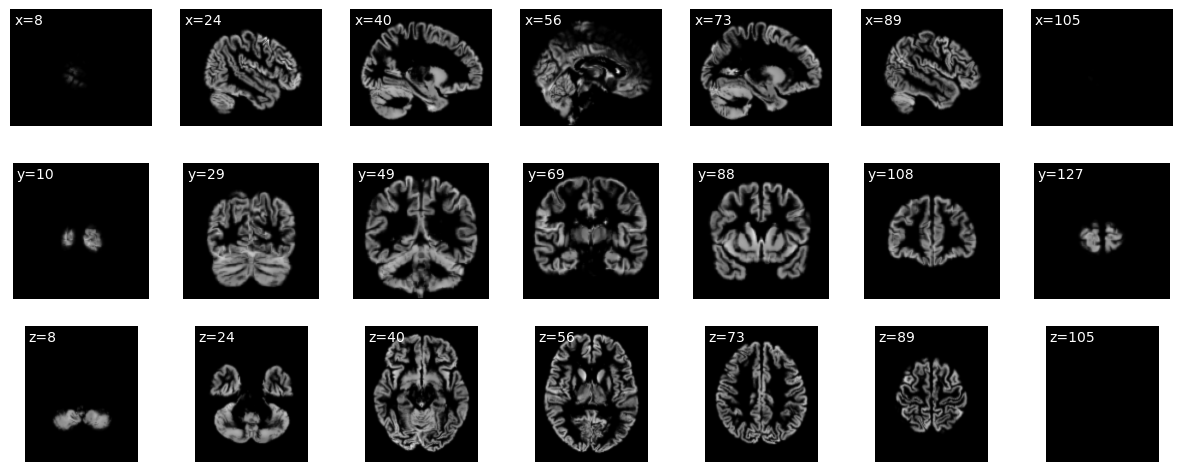

In [13]:
index = 0

image_tensor = test_dataset[index][0]
raw_image = test_dataset.get_raw_image(index)

utils.plot_slices(raw_image, num_slices=7)

## Sensitivity Analysis

In [15]:
relevance_map_backprop = interpretation.sensitivity_analysis(net, image_tensor, cuda=True, verbose=True)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
utils.plot_slices(raw_image, overlay=relevance_map_backprop[0], overlay_vmax=np.percentile(relevance_map_backprop, 99.9), overlay_cmap=utils.alpha_to_red_cmap)

NameError: name 'relevance_map_backprop' is not defined

In [ ]:
get_relevance_per_area(relevance_map_backprop[0])[:10]

[('Temporal_Mid', 0.07064282867091072),
 ('Temporal_Inf', 0.051566139656634084),
 ('Fusiform', 0.04565836059120719),
 ('ParaHippocampal', 0.04132134863210086),
 ('Hippocampus', 0.0374755911798912),
 ('Temporal_Sup', 0.03721229520496644),
 ('Thalamus', 0.036243644885147544),
 ('Lingual', 0.034998680796328466),
 ('Insula', 0.031866726200693134),
 ('Calcarine', 0.03028191870478618)]

## Guided Backpropagation

In [ ]:
relevance_map_guided = interpretation.guided_backprop(net, image_tensor, cuda=True, verbose=True)

Registered hook for layer: ReLU()
Image was classified as tensor(0, device='cuda:0') with probability tensor(0.8069, device='cuda:0')
Removing 1 hook(s)


0.0 1.1362361 0.0 0.0017148779723795034


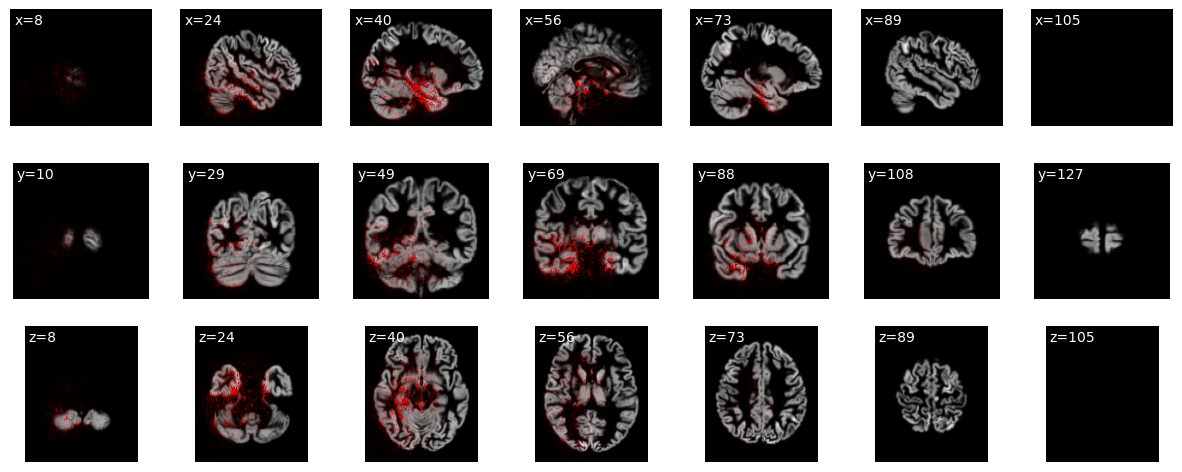

In [ ]:
utils.plot_slices(raw_image, overlay=relevance_map_guided[0], overlay_vmax=np.percentile(relevance_map_guided, 99.9))

In [ ]:
get_relevance_per_area(relevance_map_guided[0])[:10]

[('Temporal_Inf', 0.07006875476012649),
 ('ParaHippocampal', 0.06522021685907617),
 ('Temporal_Mid', 0.06207449486398902),
 ('Fusiform', 0.05844022889186704),
 ('Hippocampus', 0.053234526430273),
 ('Thalamus', 0.03314708076325478),
 ('Lingual', 0.0318137936643173),
 ('Temporal_Sup', 0.03098683394381138),
 ('Cerebelum_8', 0.03018256758764945),
 ('Cerebelum_Crus1', 0.029518369593968034)]

## Occlusion

In [ ]:
relevance_map_occlusion = interpretation.occlusion(net, image_tensor, size=40, stride=25, cuda=True, resize=True, verbose=True)

Image was classified as 0 with probability tensor(0.8069)


c:\AD_Detection_v2\interpretation.py:184: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(output)


x:   0%|          | 0/5 [00:00<?, ?it/s]

y:   0%|          | 0/6 [00:00<?, ?it/s]

z:   0%|          | 0/5 [00:00<?, ?it/s]

c:\AD_Detection_v2\interpretation.py:238: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(output)


0.0 1.1362361 0.0 0.7015924453735352


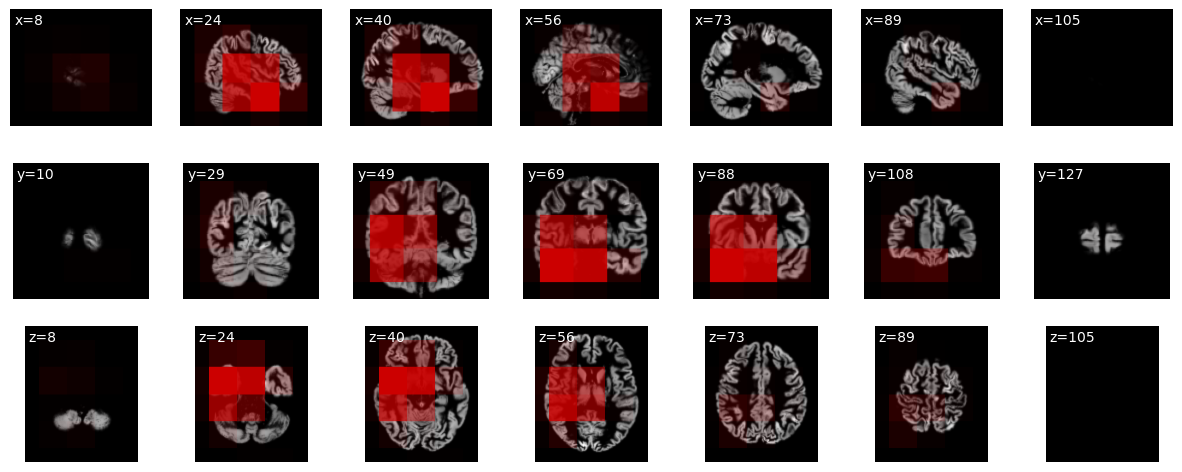

In [ ]:
utils.plot_slices(raw_image, overlay=relevance_map_occlusion, overlay_cmap=utils.alpha_to_red_cmap)

0.0 1.1362361 0.0 0.7015924453735352


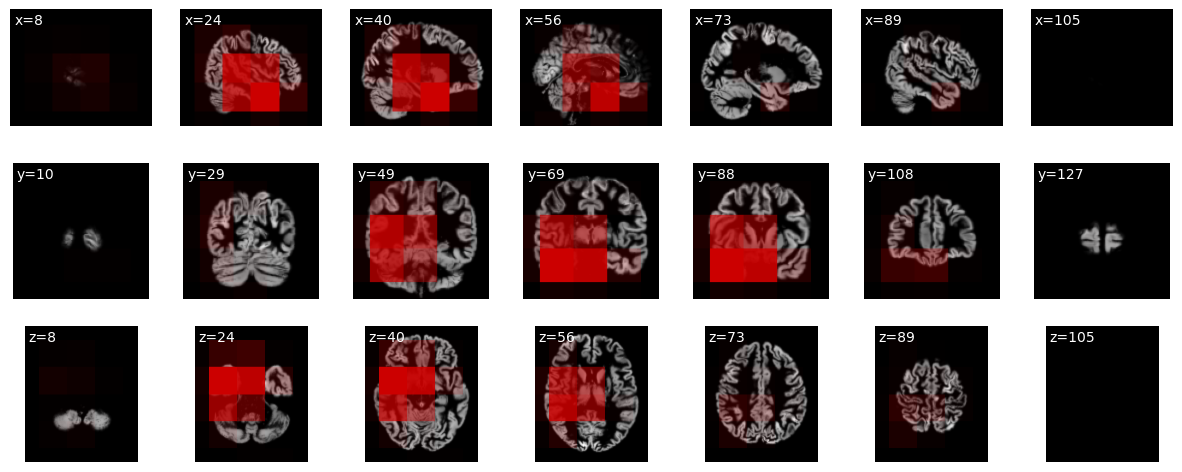

In [ ]:
utils.plot_slices(raw_image, overlay=relevance_map_occlusion, overlay_cmap=utils.alpha_to_red_cmap)

In [ ]:
get_relevance_per_area(relevance_map_occlusion)[:10]

[('Temporal_Mid', 0.09165817319628265),
 ('Temporal_Inf', 0.0634858627255816),
 ('Temporal_Sup', 0.04854681277749691),
 ('Fusiform', 0.037727959097965655),
 ('Precuneus', 0.037069864059410824),
 ('Postcentral', 0.0357839500762676),
 ('Insula', 0.03431931018312009),
 ('Temporal_Pole_Sup', 0.03321781572658926),
 ('Cingulum_Mid', 0.02967281691371388),
 ('ParaHippocampal', 0.026439670694241676)]

(-0.5, 112.5, 112.5, -0.5)

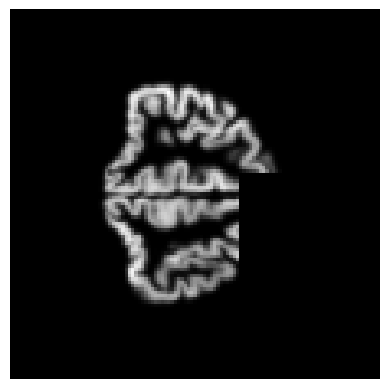

In [ ]:
# Plot occlusion patch on image.
occluded_image = raw_image[:, 114, :].copy()
size = 40
occluded_image[50:50+size, 70:70+size] = 0
plt.imshow(occluded_image, cmap='gray')
plt.axis('off')

## Area Occlusion

In [ ]:
relevance_map_area_occlusion = interpretation.area_occlusion(net, image_tensor, area_masks, cuda=True, verbose=True)

Image was classified as 0 with probability tensor(0.8069, device='cuda:0')


c:\AD_Detection_v2\interpretation.py:289: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(output)


  0%|          | 0/116 [00:00<?, ?it/s]

c:\AD_Detection_v2\interpretation.py:310: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(output)


0.0 1.1362361 0.0 0.3158104


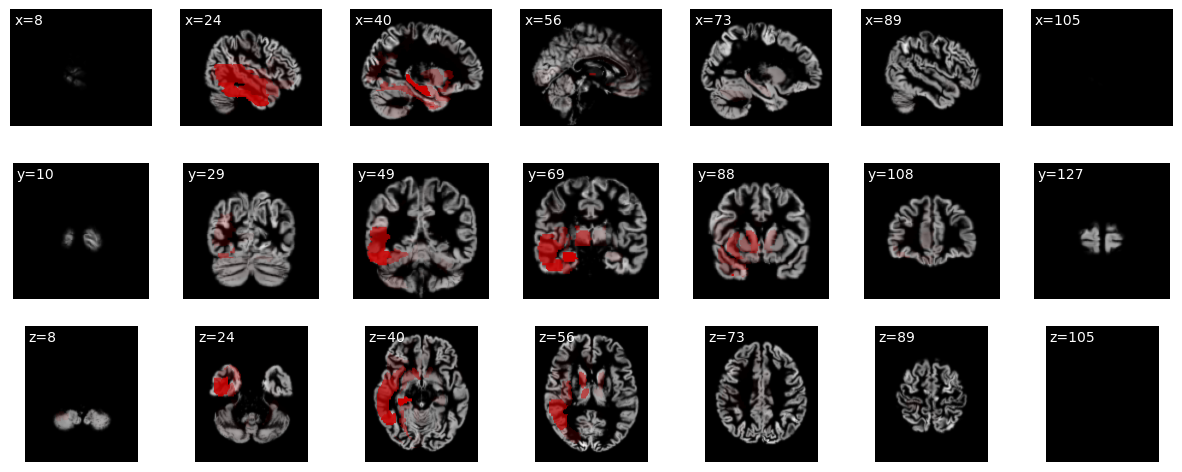

In [ ]:
utils.plot_slices(raw_image, overlay=relevance_map_area_occlusion, overlay_cmap=utils.alpha_to_red_cmap)#, overlay_vmin=0, overlay_vmax=1)

In [ ]:
get_relevance_per_area(relevance_map_area_occlusion)[:10]

[('Temporal_Mid', 0.21345553007357346),
 ('Temporal_Inf', 0.16988043749644874),
 ('Temporal_Sup', 0.09402690167201065),
 ('Fusiform', 0.06552196294565245),
 ('Hippocampus', 0.06131669720293225),
 ('Insula', 0.05289347478224219),
 ('Caudate', 0.04274035219405532),
 ('Thalamus', 0.04034656465240562),
 ('Occipital_Mid', 0.034089572259144),
 ('Temporal_Pole_Sup', 0.029484064976023874)]

# Relevance heatmaps averaged over the dataset
Plot an average relevance map of all Alzheimer and all control patients (in the test set). These are the kind of plots that are included in the paper.

In [ ]:
# If None, average over the entire dataset, otherwise pick a number of samples.
num_samples=None




0.0 0.82151663 None None


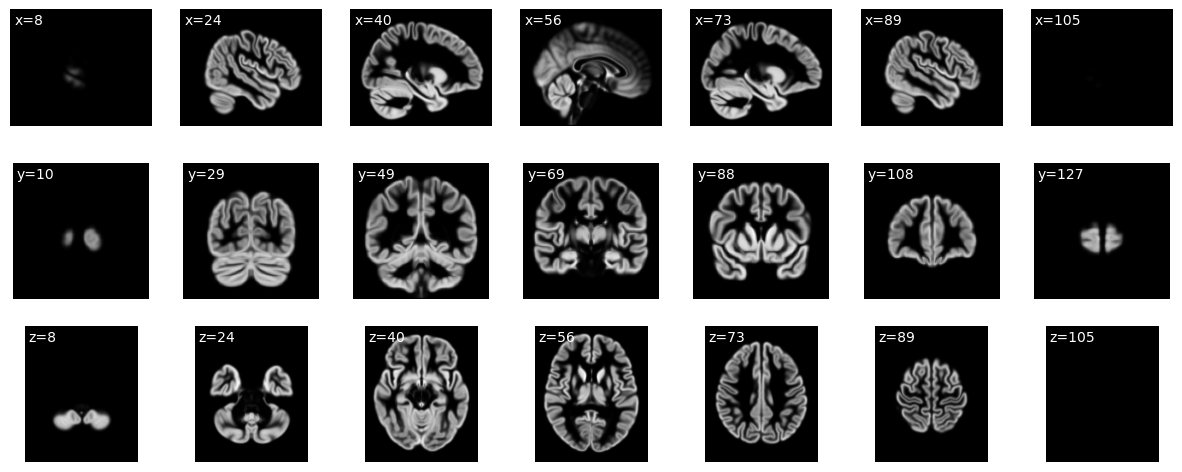

In [ ]:
# Code to generate background over which to plot the heatmaps.

import nibabel as nib
image_sum = None
num_images = len(test_dataset)

for idx in range(num_images):
    # Load the image using the dataset's get_raw_image function
    image = test_dataset.get_raw_image(idx)  # shape: (D, H, W), where D is depth, H is height, W is width
    
    # Ensure the image is in the correct format
    if image_sum is None:
        image_sum = image
    else:
        image_sum += image

# Calculate the average image
average_image = image_sum / num_images

# Save the average image as a NIfTI file
average_image_nifti = nib.Nifti1Image(average_image, np.eye(4))
nib.save(average_image_nifti, 'average_image.nii')

utils.plot_slices(utils.load_nifti('average_image.nii'),num_slices=7)



In [ ]:
bg = utils.load_nifti('average_image.nii')

## Backpropagation

In [ ]:
avg_relevance_map_AD_backprop, avg_relevance_map_NC_backprop, avg_relevance_map_all_backprop = interpretation.average_over_dataset(interpretation.sensitivity_analysis, net, test_dataset, num_samples=num_samples, seed=0, show_progress=True, cuda=True)

  0%|          | 0/103 [00:00<?, ?it/s]

0.0 0.82151663 0.0 0.0023488783221692323


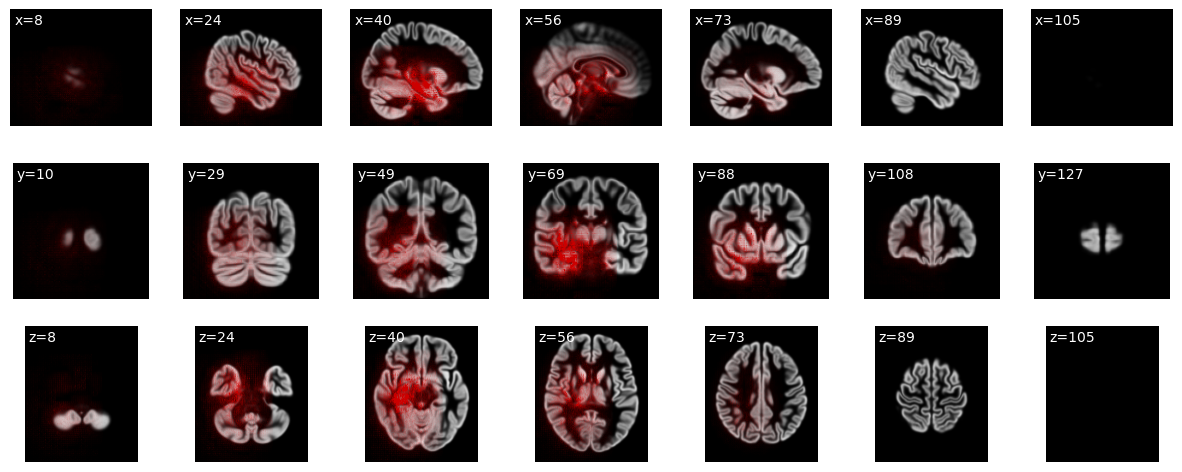

In [ ]:
utils.plot_slices(bg, overlay=avg_relevance_map_AD_backprop[0], overlay_vmax=np.percentile(avg_relevance_map_AD_backprop, 99.9))

In [ ]:
get_relevance_per_area(avg_relevance_map_AD_backprop)[:10]

[('Temporal_Mid', 0.06611708252947378),
 ('Temporal_Inf', 0.04765838639576115),
 ('Fusiform', 0.04384696787687282),
 ('Lingual', 0.04183842561477001),
 ('Temporal_Sup', 0.03824098873537532),
 ('Hippocampus', 0.03647824477899889),
 ('ParaHippocampal', 0.03575608559300207),
 ('Calcarine', 0.035067326636364485),
 ('Thalamus', 0.03492479990326991),
 ('Insula', 0.03079985179547275)]

0.0 0.82151663 0.0 0.0028332790434360913


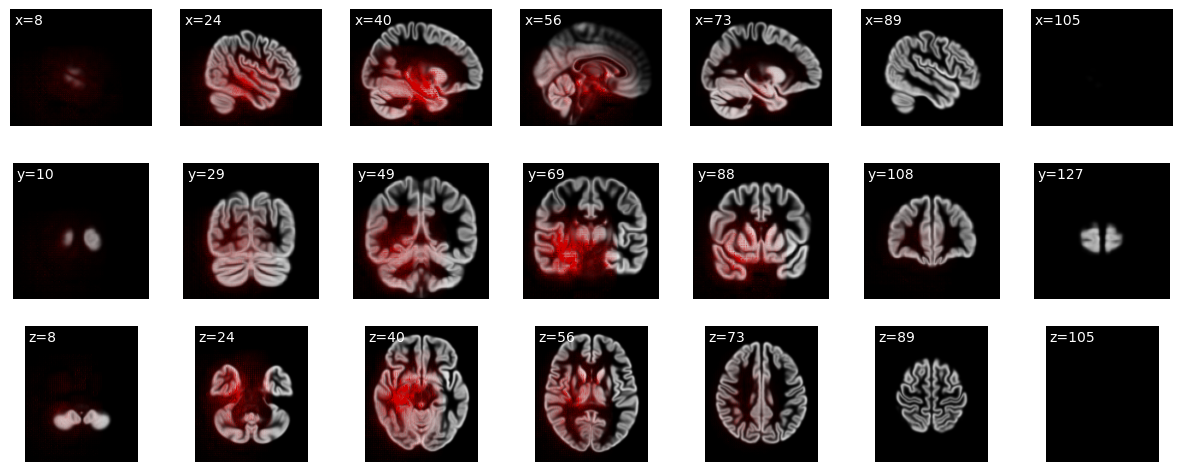

In [ ]:
utils.plot_slices(bg, overlay=avg_relevance_map_NC_backprop[0], overlay_vmax=np.percentile(avg_relevance_map_NC_backprop, 99.9))

In [ ]:
get_relevance_per_area(avg_relevance_map_NC_backprop)[:10]

[('Temporal_Mid', 0.0679981252284555),
 ('Temporal_Inf', 0.050345066638774666),
 ('Fusiform', 0.04595420786976964),
 ('Lingual', 0.04085737005373047),
 ('Temporal_Sup', 0.038459386090391644),
 ('Hippocampus', 0.03760037057737131),
 ('ParaHippocampal', 0.03747324677546766),
 ('Thalamus', 0.03526365972025032),
 ('Calcarine', 0.03336068376745482),
 ('Insula', 0.030661123023253724)]

## Guided Backpropagation

In [ ]:
avg_relevance_map_AD_guided, avg_relevance_map_NC_guided, avg_relevance_map_all_guided = interpretation.average_over_dataset(interpretation.guided_backprop, net, test_dataset, num_samples=num_samples, seed=0, show_progress=True, cuda=True)

  0%|          | 0/103 [00:00<?, ?it/s]

0.0 0.82151663 0.0 0.0008357521230355173


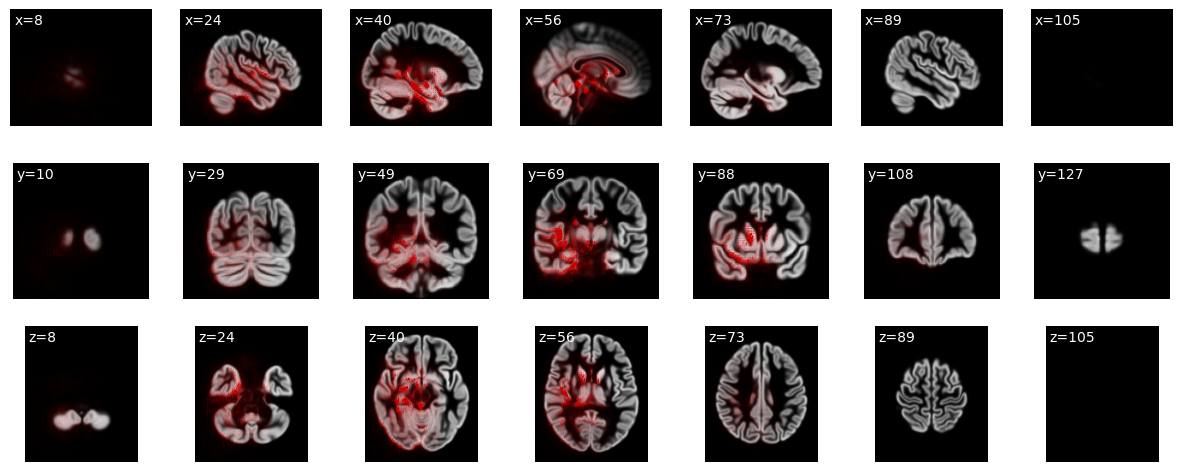

In [ ]:
utils.plot_slices(bg, overlay=avg_relevance_map_AD_guided[0], overlay_vmax=np.percentile(avg_relevance_map_AD_guided, 99.9))

In [ ]:
get_relevance_per_area(avg_relevance_map_AD_guided)[:10]

[('Temporal_Mid', 0.05767194493579298),
 ('Lingual', 0.046539879228729965),
 ('Temporal_Inf', 0.04363389518052645),
 ('Temporal_Sup', 0.04179747746721582),
 ('Fusiform', 0.041237547073738764),
 ('Calcarine', 0.039704702854070725),
 ('ParaHippocampal', 0.03579406773812209),
 ('Hippocampus', 0.03247797192668857),
 ('Thalamus', 0.0318908865150901),
 ('Precuneus', 0.031277169132447616)]

0.0 0.82151663 0.0 0.0010219846479594865


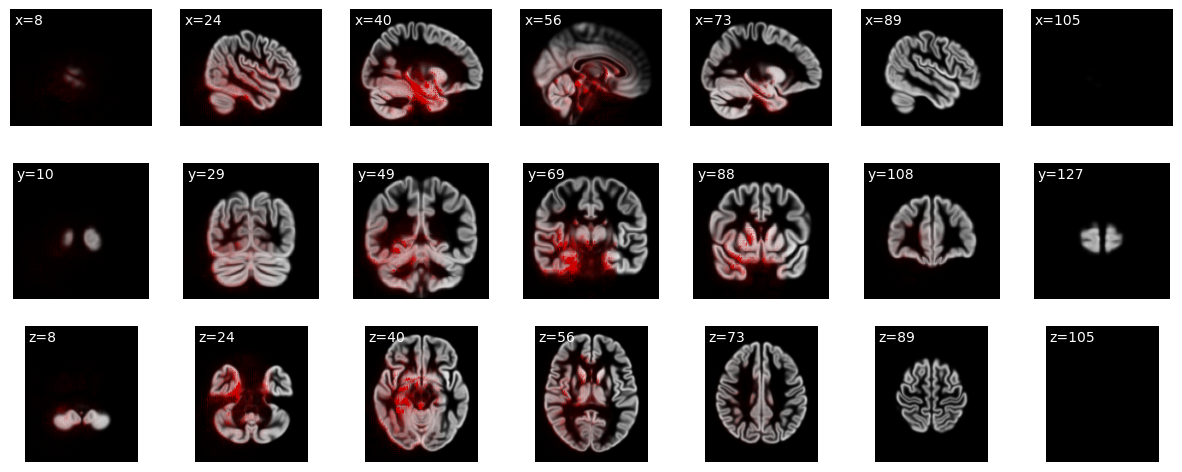

In [ ]:
utils.plot_slices(bg, overlay=avg_relevance_map_NC_guided[0], overlay_vmax=np.percentile(avg_relevance_map_NC_guided, 99.9))

In [ ]:
get_relevance_per_area(avg_relevance_map_NC_guided)[:10]

[('ParaHippocampal', 0.05574040123922201),
 ('Temporal_Mid', 0.055704626593825114),
 ('Fusiform', 0.05496984520737234),
 ('Temporal_Inf', 0.052550030325114766),
 ('Hippocampus', 0.04647786524354871),
 ('Lingual', 0.043539220164415554),
 ('Calcarine', 0.032738708690073684),
 ('Thalamus', 0.03217093095038419),
 ('Cerebelum_Crus1', 0.030514476495491386),
 ('Cerebelum_4_5', 0.030369456047192073)]

## Occlusion

In [ ]:
avg_relevance_map_AD_occlusion, avg_relevance_map_NC_occlusion, avg_relevance_map_all_occlusion = interpretation.average_over_dataset(interpretation.occlusion, net, test_dataset, num_samples=num_samples, show_progress=True, size=40, stride=40, cuda=True)

  0%|          | 0/103 [00:00<?, ?it/s]

0.0 0.82151663 1.655684577094184e-09 0.09607719050513373


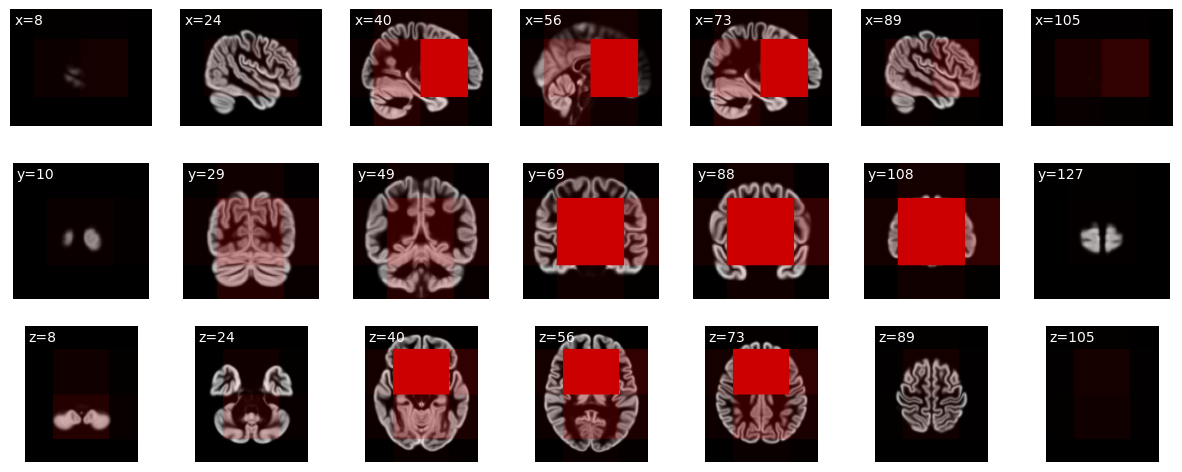

In [ ]:
utils.plot_slices(bg, overlay=avg_relevance_map_AD_occlusion, overlay_cmap=utils.alpha_to_red_cmap)

In [ ]:
get_relevance_per_area(avg_relevance_map_AD_occlusion)[:10]

[('Frontal_Mid', 0.11360572216120443),
 ('Frontal_Sup', 0.061578907111407497),
 ('Insula', 0.04695677741051119),
 ('Frontal_Sup_Medial', 0.04404220804626763),
 ('Precentral', 0.040840080920148014),
 ('Cingulum_Mid', 0.03903971730141263),
 ('Cingulum_Ant', 0.038654088409488835),
 ('Supp_Motor_Area', 0.03662309648579517),
 ('Frontal_Inf_Orb', 0.03579906896329191),
 ('Frontal_Inf_Tri', 0.03152053862708189)]

0.0 0.82151663 3.5584862552472014e-09 0.3901555351356962


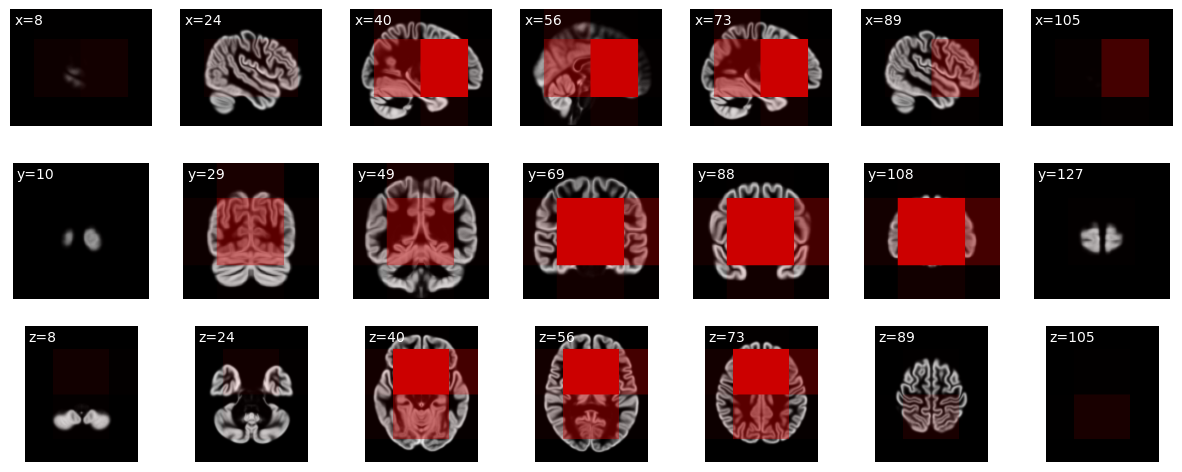

In [ ]:
utils.plot_slices(bg, overlay=avg_relevance_map_NC_occlusion, overlay_cmap=utils.alpha_to_red_cmap)

In [ ]:
get_relevance_per_area(avg_relevance_map_NC_occlusion)[:10]

[('Frontal_Mid', 0.1052285010438155),
 ('Frontal_Sup', 0.054813337035388404),
 ('Insula', 0.0438656178748366),
 ('Frontal_Sup_Medial', 0.04037200453780171),
 ('Cingulum_Mid', 0.04017056003596932),
 ('Precentral', 0.039571976180180615),
 ('Cingulum_Ant', 0.03552860898339315),
 ('Precuneus', 0.034337587589591975),
 ('Frontal_Inf_Orb', 0.033645903079927375),
 ('Supp_Motor_Area', 0.031925545353035545)]

## Area Occlusion

In [ ]:
avg_relevance_map_AD_area_occlusion, avg_relevance_map_NC_area_occlusion, avg_relevance_map_all_area_occlusion = interpretation.average_over_dataset(interpretation.area_occlusion, net, test_dataset, num_samples=num_samples, seed=0, show_progress=True, cuda=True, area_masks=area_masks)

  0%|          | 0/103 [00:00<?, ?it/s]

0.0 0.82151663 0.0 0.040870737


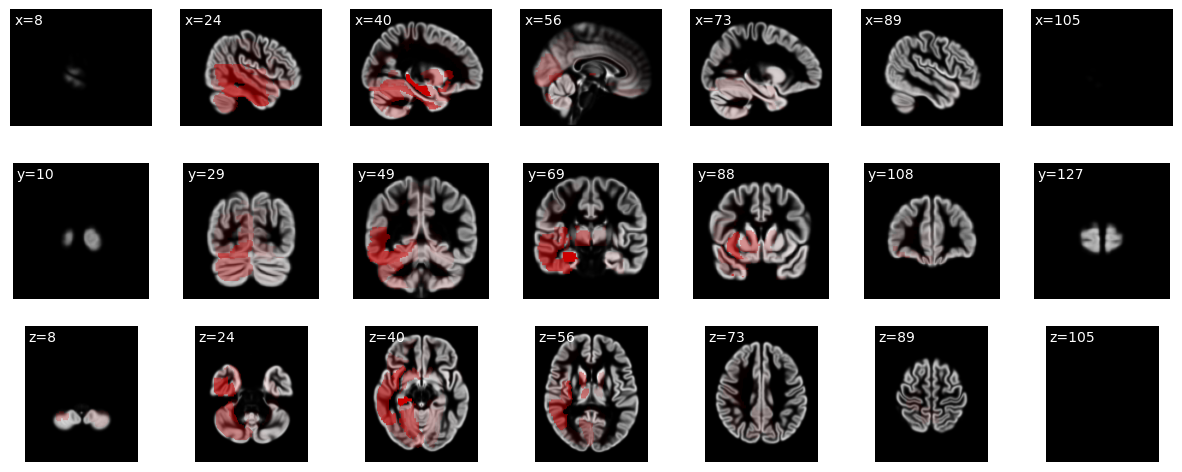

In [ ]:
utils.plot_slices(bg, overlay=avg_relevance_map_AD_area_occlusion, overlay_cmap=utils.alpha_to_red_cmap)

In [ ]:
get_relevance_per_area(avg_relevance_map_AD_area_occlusion)[:10]

[('Temporal_Mid', 0.1215902516759607),
 ('Temporal_Inf', 0.0919926269833352),
 ('Fusiform', 0.07399022670844235),
 ('Lingual', 0.0605154579181507),
 ('Insula', 0.053324761472172244),
 ('Temporal_Sup', 0.04867838689898442),
 ('Cerebelum_6', 0.04619939845523739),
 ('Hippocampus', 0.045035220284049375),
 ('Cerebelum_Crus1', 0.0411701151786555),
 ('Calcarine', 0.03567193934383844)]

0.0 0.82151663 0.0 0.23074096


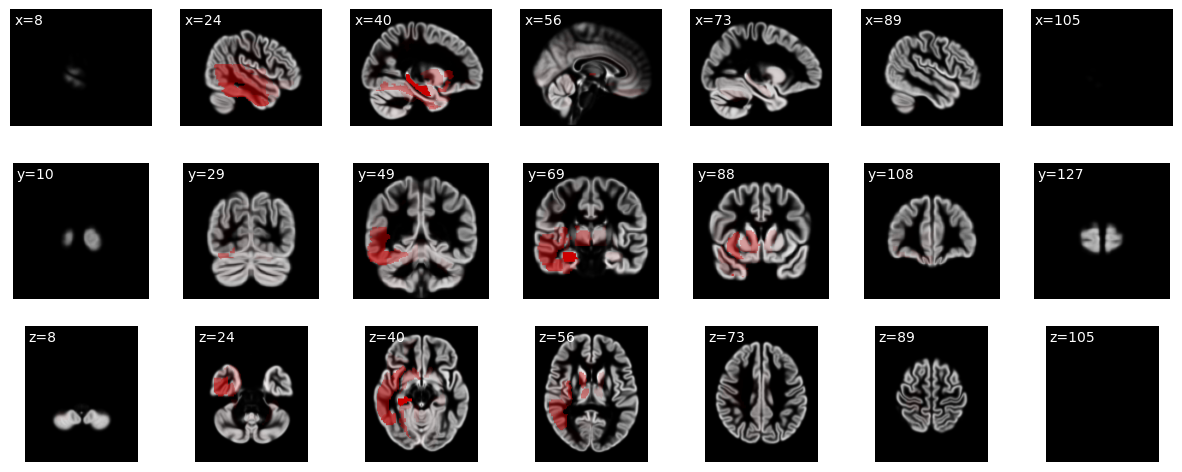

In [ ]:
utils.plot_slices(bg, overlay=avg_relevance_map_NC_area_occlusion)

In [ ]:
get_relevance_per_area(avg_relevance_map_NC_area_occlusion)[:10]

[('Temporal_Mid', 0.18901773028389462),
 ('Temporal_Inf', 0.15122304312751256),
 ('Fusiform', 0.07821068641642007),
 ('Hippocampus', 0.07620944058455412),
 ('Insula', 0.07475926105980353),
 ('Temporal_Sup', 0.07364633368224315),
 ('Caudate', 0.04141695529492775),
 ('Thalamus', 0.03944818485286225),
 ('Putamen', 0.02376853676265611),
 ('Temporal_Pole_Sup', 0.022675220514078352)]

## Save average heatmaps

In [ ]:
# Save heatmaps to file.
np.savez_compressed('output/relevance_maps_final_compressed.npz', **{
   'avg_relevance_map_AD_backprop': avg_relevance_map_AD_backprop,
   'avg_relevance_map_AD_guided': avg_relevance_map_AD_guided,
   'avg_relevance_map_AD_occlusion': avg_relevance_map_AD_occlusion,
   'avg_relevance_map_AD_area_occlusion': avg_relevance_map_AD_area_occlusion,

   'avg_relevance_map_NC_backprop': avg_relevance_map_NC_backprop,
   'avg_relevance_map_NC_guided': avg_relevance_map_NC_guided,
   'avg_relevance_map_NC_occlusion': avg_relevance_map_NC_occlusion,
   'avg_relevance_map_NC_area_occlusion': avg_relevance_map_NC_area_occlusion,
})

# Figures and tables for paper

In [ ]:
# Load heatmaps from file.
loaded_heatmaps = np.load('output/relevance_maps_final_compressed.npz')
avg_relevance_map_AD_backprop = loaded_heatmaps['avg_relevance_map_AD_backprop']
avg_relevance_map_AD_guided = loaded_heatmaps['avg_relevance_map_AD_guided']
avg_relevance_map_AD_occlusion = loaded_heatmaps['avg_relevance_map_AD_occlusion']
avg_relevance_map_AD_area_occlusion = loaded_heatmaps['avg_relevance_map_AD_area_occlusion']
avg_relevance_map_NC_backprop = loaded_heatmaps['avg_relevance_map_NC_backprop']
avg_relevance_map_NC_guided = loaded_heatmaps['avg_relevance_map_NC_guided']
avg_relevance_map_NC_occlusion = loaded_heatmaps['avg_relevance_map_NC_occlusion']
avg_relevance_map_NC_area_occlusion = loaded_heatmaps['avg_relevance_map_NC_area_occlusion']

## Figure 1 (Average heatmaps)

In [ ]:
def plot_column(struct_arr, axes, title, cmap='gray', vmin=None, vmax=None, overlay=None, overlay_cmap=utils.alpha_to_red_cmap, overlay_vmin=None, overlay_vmax=None):
    if vmin is None:
        vmin = struct_arr.min()
    if vmax is None:
        vmax = struct_arr.max()
    if overlay_vmin is None and overlay is not None:
        overlay_vmin = overlay.min()
    if overlay_vmax is None and overlay is not None:
        overlay_vmax = overlay.max()
    print(vmin, vmax, overlay_vmin, overlay_vmax)

    offset = 80
    num_slices = len(axes)

    intervals = (np.asarray(struct_arr.shape) - 2 * offset) / (num_slices - 1)

    axis = 1
    axis_label = 'y'

    #for axes_column in zip(titles):

    for i, ax in enumerate(axes):
        #print(axis_label, 'plotting slice', i_slice)
        i_slice = int(np.round(offset + i * intervals[axis]))

        plt.sca(ax)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        #plt.axis('off')
        plt.imshow(sp.ndimage.rotate(np.take(struct_arr, i_slice, axis=axis), 90), vmin=vmin, vmax=vmax,
                   cmap=cmap, interpolation=None)
        plt.text(0.03, 0.97, '{}'.format(i_slice), color='white',
                 horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)

        if overlay is not None:
            plt.imshow(sp.ndimage.rotate(np.take(overlay, i_slice, axis=axis), 90), cmap=overlay_cmap,
                       vmin=overlay_vmin, vmax=overlay_vmax, interpolation=None)

        if i == 0:
            plt.title(title + '\n')
            #plt.ylabel('Backpropagation', rotation=0, size='large')
            #ax.get_yaxis().set_label_coords(-0.5, 0.5)

In [ ]:
# print(bg.max())

# HeatMap for AD

0.0 0.82151663 0.0 0.0023488783221692323
0.0 0.82151663 0.0 0.0008357521230355173
0.0 0.82151663 1.655684577094184e-09 0.09607719050513373
0.0 0.82151663 0.0 0.040870737


C:\Users\amana\AppData\Local\Temp\ipykernel_2824\3803725943.py:16: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


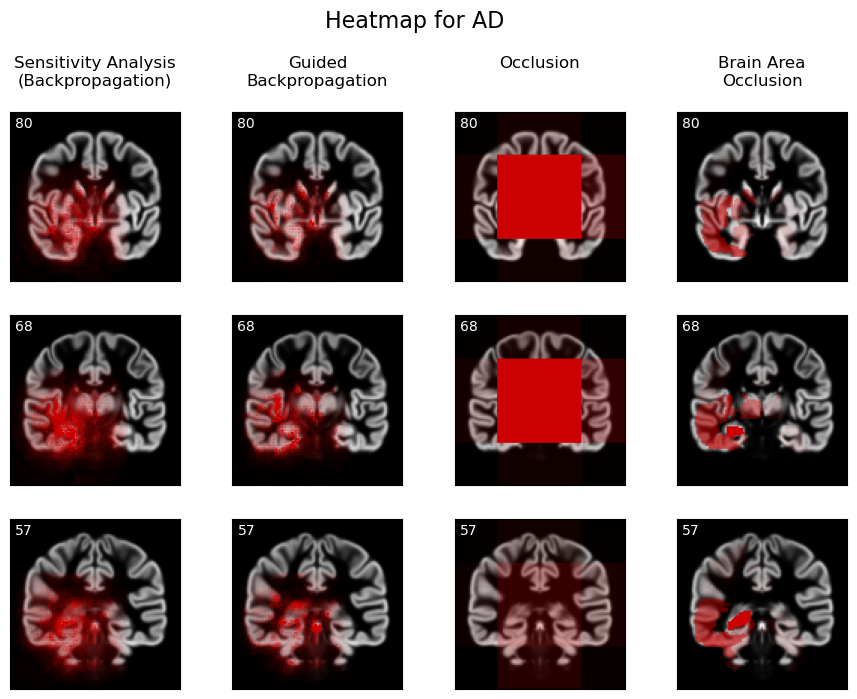

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(11, 7.5))
axes = axes.T

#bg = mask
# bg = test_dataset.mean
bg = utils.load_nifti('average_image.nii')

vmax = bg.max()  # make the background brain a bit lighter

plot_column(bg, axes[0], 'Sensitivity Analysis\n(Backpropagation)', overlay=avg_relevance_map_AD_backprop[0], overlay_vmax=np.percentile(avg_relevance_map_AD_backprop, 99.9), vmax=vmax)
plot_column(bg, axes[1], 'Guided\nBackpropagation', overlay=avg_relevance_map_AD_guided[0], overlay_vmax=np.percentile(avg_relevance_map_AD_guided, 99.9), vmax=vmax)
plot_column(bg, axes[2], 'Occlusion\n', overlay=avg_relevance_map_AD_occlusion, vmax=vmax)
plot_column(bg, axes[3], 'Brain Area\nOcclusion', overlay=avg_relevance_map_AD_area_occlusion, vmax=vmax)
#plot_column(bg, axes[4], 'Grad-CAM\n', overlay=avg_relevance_map_AD_grad_cam, vmax=vmax)
plt.text(0.5, 1, 'Heatmap for AD', fontsize=16, ha='center', va='center', transform=fig.transFigure)
plt.tight_layout()

#plt.savefig('heatmaps-nc.png', dpi=300)

# HeatMap for CN

0.0 0.82151663 0.0 0.0028332790434360913
0.0 0.82151663 0.0 0.0010219846479594865
0.0 0.82151663 3.5584862552472014e-09 0.3901555351356962
0.0 0.82151663 0.0 0.23074096


C:\Users\amana\AppData\Local\Temp\ipykernel_2824\1668469578.py:17: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


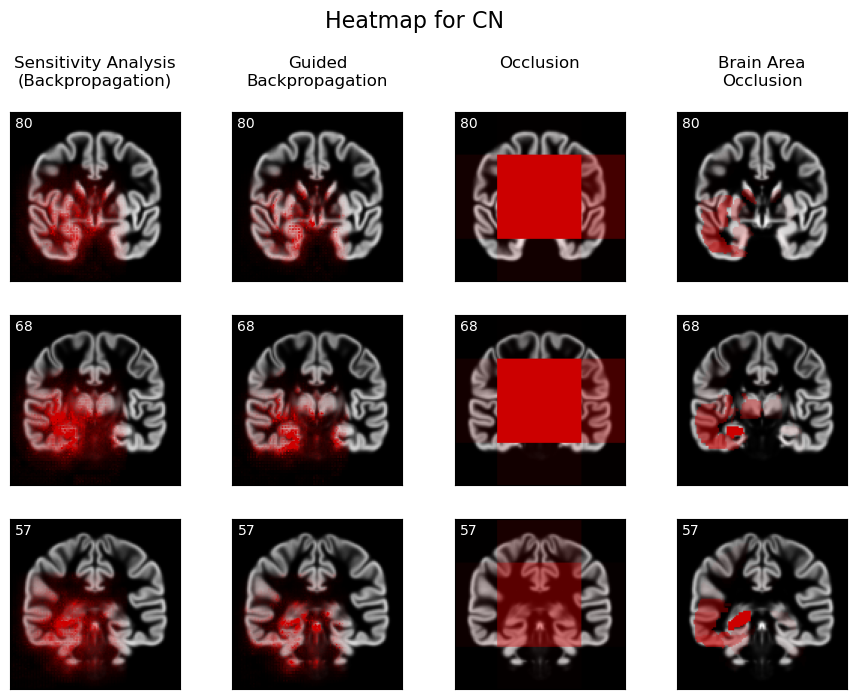

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(11, 7.5))
axes = axes.T

#bg = mask
# bg = test_dataset.mean
bg = utils.load_nifti('average_image.nii')

vmax = bg.max()  # make the background brain a bit lighter

plot_column(bg, axes[0], 'Sensitivity Analysis\n(Backpropagation)', overlay=avg_relevance_map_NC_backprop[0], overlay_vmax=np.percentile(avg_relevance_map_NC_backprop, 99.9), vmax=vmax)
plot_column(bg, axes[1], 'Guided\nBackpropagation', overlay=avg_relevance_map_NC_guided[0], overlay_vmax=np.percentile(avg_relevance_map_NC_guided, 99.9), vmax=vmax)
plot_column(bg, axes[2], 'Occlusion\n', overlay=avg_relevance_map_NC_occlusion, vmax=vmax)
plot_column(bg, axes[3], 'Brain Area\nOcclusion', overlay=avg_relevance_map_NC_area_occlusion, vmax=vmax)
#plot_column(bg, axes[4], 'Grad-CAM\n', overlay=avg_relevance_map_AD_grad_cam, vmax=vmax)
plt.text(0.5, 1, 'Heatmap for CN', fontsize=16, ha='center', va='center', transform=fig.transFigure)

plt.tight_layout()

#plt.savefig('heatmaps-nc.png', dpi=300)

## Table 1 (Most relevant brain areas)

In [ ]:
most_relevant_areas_per_method = [
    get_relevance_per_area(avg_relevance_map_AD_backprop)[:4],
    get_relevance_per_area(avg_relevance_map_AD_guided)[:4],
    get_relevance_per_area(avg_relevance_map_AD_occlusion)[:4],
    get_relevance_per_area(avg_relevance_map_AD_area_occlusion)[:4]#,
    #get_relevance_per_area(avg_relevance_map_AD_grad_cam)[:4]
]

In [ ]:
lines = []
for i in range(len(most_relevant_areas_per_method[0])):
    line = ' & '.join(['{} ({:.1f} \\%)'.format(areas[i][0].replace('_', ''), areas[i][1]*100) for areas in most_relevant_areas_per_method])
    lines.append(line)
print(' \\\\ \n'.join(lines))  # output in latex format

TemporalMid (6.6 \%) & TemporalMid (5.8 \%) & FrontalMid (11.4 \%) & TemporalMid (12.2 \%) \\ 
TemporalInf (4.8 \%) & Lingual (4.7 \%) & FrontalSup (6.2 \%) & TemporalInf (9.2 \%) \\ 
Fusiform (4.4 \%) & TemporalInf (4.4 \%) & Insula (4.7 \%) & Fusiform (7.4 \%) \\ 
Lingual (4.2 \%) & TemporalSup (4.2 \%) & FrontalSupMedial (4.4 \%) & Lingual (6.1 \%)


In [ ]:
most_relevant_areas_per_method = [
    get_relevance_per_area(avg_relevance_map_NC_backprop)[:4],
    get_relevance_per_area(avg_relevance_map_NC_guided)[:4],
    get_relevance_per_area(avg_relevance_map_NC_occlusion)[:4],
    get_relevance_per_area(avg_relevance_map_NC_area_occlusion)[:4]#,
    #get_relevance_per_area(avg_relevance_map_AD_grad_cam)[:4]
]

In [ ]:
lines = []
for i in range(len(most_relevant_areas_per_method[0])):
    line = ' & '.join(['{} ({:.1f} \\%)'.format(areas[i][0].replace('_', ''), areas[i][1]*100) for areas in most_relevant_areas_per_method])
    lines.append(line)
print(' \\\\ \n'.join(lines))  # output in latex format

TemporalMid (6.8 \%) & ParaHippocampal (5.6 \%) & FrontalMid (10.5 \%) & TemporalMid (18.9 \%) \\ 
TemporalInf (5.0 \%) & TemporalMid (5.6 \%) & FrontalSup (5.5 \%) & TemporalInf (15.1 \%) \\ 
Fusiform (4.6 \%) & Fusiform (5.5 \%) & Insula (4.4 \%) & Fusiform (7.8 \%) \\ 
Lingual (4.1 \%) & TemporalInf (5.3 \%) & FrontalSupMedial (4.0 \%) & Hippocampus (7.6 \%)


## Table 2 (Euclidean distances between heatmaps)

In [ ]:
relevance_maps_AD = [avg_relevance_map_AD_backprop, avg_relevance_map_AD_guided, avg_relevance_map_AD_occlusion, avg_relevance_map_AD_area_occlusion]
relevance_maps_NC = [avg_relevance_map_NC_backprop, avg_relevance_map_NC_guided, avg_relevance_map_NC_occlusion, avg_relevance_map_NC_area_occlusion]
names = ['backprop ', 'guided   ', 'occlusion', 'area occl']

In [ ]:
scale_factor = 1e-4

print('Euclidean distance between average heatmaps for AD / NC samples in {}'.format(scale_factor))
print()

print('\t\t' + '\t'.join(names))

for a_AD, a_NC, a_name in zip(relevance_maps_AD, relevance_maps_NC, names):
    print(a_name, end='\t')
    for b_AD, b_NC, b_name in zip(relevance_maps_AD, relevance_maps_NC, names):
        print('{:.2f} / {:.2f}'.format(interpretation.heatmap_distance(a_AD, b_AD) / scale_factor, interpretation.heatmap_distance(a_NC, b_NC) / scale_factor), end='\t')
    print()

Euclidean distance between average heatmaps for AD / NC samples in 0.0001

		backprop 	guided   	occlusion	area occl
backprop 	0.00 / 0.00	8.88 / 9.08	17.27 / 17.45	24.10 / 34.05	
guided   	8.88 / 9.08	0.00 / 0.00	20.08 / 20.62	25.40 / 35.07	
occlusion	17.27 / 17.45	20.08 / 20.62	0.00 / 0.00	29.78 / 39.66	
area occl	24.10 / 34.05	25.40 / 35.07	29.78 / 39.66	0.00 / 0.00	


In [ ]:
print('Euclidean distance between AD and NC heatmaps for each method in {}'.format(scale_factor))
print()

print('\t'.join(names))
for a, b in zip(relevance_maps_AD, relevance_maps_NC):
    print('{:.2f}'.format(interpretation.heatmap_distance(a, b) / scale_factor), end='\t\t')

Euclidean distance between AD and NC heatmaps for each method in 0.0001

backprop 	guided   	occlusion	area occl
3.69		7.65		3.45		19.13		

# Export to Animation and MRIcron

In [ ]:
bg = utils.load_nifti('average_image.nii')

anim = utils.animate_slices(bg, overlay=avg_relevance_map_AD_guided[0], overlay_vmax=np.percentile(avg_relevance_map_AD_guided, 99.9), axis=2, reverse_direction=True, interval=70)
plt.close()  # suppress plot output

In [ ]:
plt.rcParams['animation.ffmpeg_path'] = u'/home/johannesr/ffmpeg-3.4.1-64bit-static/ffmpeg'

In [ ]:
# # Display the animation inline.
# from IPython.display import HTML
# HTML(anim.to_html5_video())

In [ ]:
anim.save('data/anim-guided.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


In [ ]:
# You can also save the relevance map in NIFTI format and load it as an overlay in MRIcron (https://www.nitrc.org/projects/mricron) later.
#utils.save_nifti('guided_backprop.nii', relevance_map_guided[0])